In [2]:
import requests

def get_daily_links(base_link):
    
    downloads_link = base_link.replace("newspapers","api.fdnl.patron") + '/downloads'
    response = requests.get(downloads_link)    

    daily_links = []
    if response.status_code == 200:
        data = response.json()
        for file_name in data['pdf']:
            if file_name.endswith('pdf'):
                file_url = f"{base_link}/{file_name}"

                # Split the URL by '/'
                parts = file_url.split('/')

                # Extract the relevant parts of the URL
                id = parts[3]
                path = '/'.join(parts[5:])

                # Reformat the URL
                new_url = f'https://ufdcimages.uflib.ufl.edu/{id[:2]}/{id[2:4]}/{id[4:6]}/{id[6:8]}/{id[8:10]}/{parts[4]}/{path}'

                daily_links.append(new_url)
                break # Only add first pdf link 
    return daily_links

def get_article_links_and_dates(url, school=None):
    from datetime import datetime
    import json
    import os

    api_url = "https://api.fdnl.patron.uflib.ufl.edu/serialhierarchy?bibid=UF00028290"

    response = requests.get(api_url)
    data = response.json()

    if os.path.exists('uf_article_pages.json'):
        # Open the JSON file for reading
        with open('uf_article_pages.json', 'r') as f:
            article_links = json.load(f)
    else:
        article_links = {}
    for year in data:
        # print(year)
        if int(year['key']) >= 2009:

            for month in year['values']:
                for entry in month['values']:
                    date_str = entry['text']
                    
                    try:
                        date = datetime.strptime(date_str, '%B %d, %Y')
                        year_month_day = date.strftime('%Y_%m_%d')
                        if year_month_day in article_links:
                            print(f"Date {year_month_day} exists.")
                            continue
                        else:
                            article_links[year_month_day] = get_daily_links(url + entry['vid'])
                            print(f"Date {year_month_day} added.")
                    except ValueError:
                        try:
                            date = datetime.strptime(f"{year['key']} {month['key']} {date_str}", '%Y %B %d')
                            year_month_day = date.strftime('%Y_%m_%d')
                            if year_month_day in article_links:
                                print(f"Date {year_month_day} exists.")
                                continue
                            else:
                                article_links[year_month_day] = get_daily_links(url + entry['vid'])
                                print(f"Date {year_month_day} added.")
                            article_links[year_month_day] = get_daily_links(url + entry['vid'])
                        except ValueError as ve:
                            # if there is an error parsing the date string, print an error message and continue to the next iteration
                            print(f"{ve} Error parsing date string: {year_month_day}")
                        except TypeError as te:
                            print(f"{te} Error parsing date string: {year_month_day}") 
                    
            print(f"{year['key']} saved to json.")
            with open("uf_article_pages.json", "w") as outfile:
                json.dump(article_links, outfile, indent=4)           
    return(article_links)

In [4]:
article_pages = get_article_links_and_dates(url="https://newspapers.uflib.ufl.edu/UF00028290/")

Date 2009_01_06 added.
Date 2009_01_07 added.
Date 2009_01_08 added.
Date 2009_01_09 added.
Date 2009_01_12 added.
Date 2009_01_13 added.
Date 2009_01_14 added.
Date 2009_01_15 added.
Date 2009_01_16 added.
Date 2009_01_20 added.
Date 2009_01_21 added.
Date 2009_01_22 added.
Date 2009_01_23 added.
Date 2009_01_26 added.
Date 2009_01_27 added.
Date 2009_01_28 added.
Date 2009_01_29 added.
Date 2009_01_30 added.
Date 2009_02_02 added.
Date 2009_02_03 added.
Date 2009_02_04 added.
Date 2009_02_05 added.
Date 2009_02_06 added.
Date 2009_02_09 added.
Date 2009_02_10 added.
Date 2009_02_11 added.
Date 2009_02_12 added.
Date 2009_02_13 added.
Date 2009_02_16 added.
Date 2009_02_17 added.
Date 2009_02_18 added.
Date 2009_02_19 added.
Date 2009_02_20 added.
Date 2009_02_23 added.
Date 2009_02_24 added.
Date 2009_02_25 added.
Date 2009_02_26 added.
Date 2009_02_27 added.
Date 2009_03_02 added.
Date 2009_03_03 added.
Date 2009_03_04 added.
Date 2009_03_05 added.
Date 2009_03_06 added.
Date 2009_0

In [4]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 1804 dates with articles
There are 1804 articles to iterate over


In [ ]:
from helpers.pdf_to_text import extract_pdf_text
from helpers.make_txt_entry import make_txt_entry
import os

school_name = "UF"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = extract_pdf_text(articles[0])
            
        make_txt_entry(school_name="UF", publication_date=date, text=article_text)
        print(f"Date {date} added.")

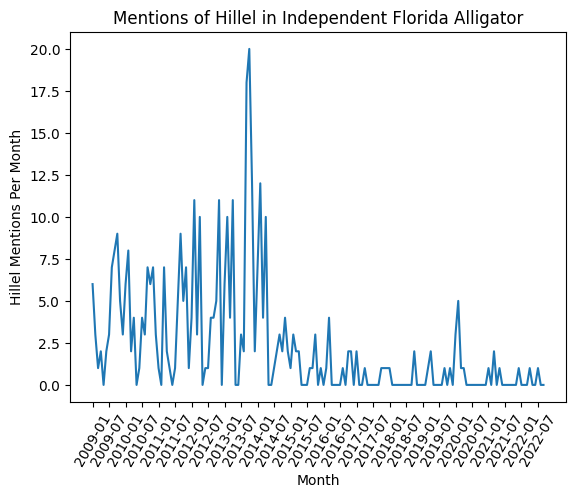

In [4]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter

directory = 'journal_data/txt/UF'
UF_pipeline = [] # No pipeline or processing for now

monthly_grapher(directory=directory,
                pipeline=UF_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in Independent Florida Alligator",
                save_path='figures/UF/UF_hillel_mentions.png')

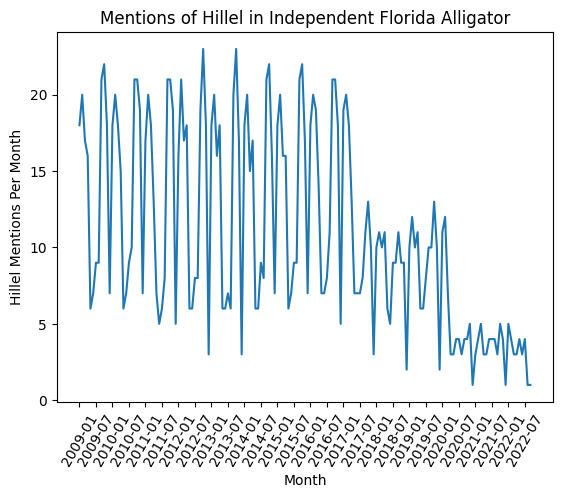

In [5]:
from helpers.graphers import monthly_grapher
from helpers.queries import one_query

directory = 'journal_data/txt/UF'

monthly_grapher(directory=directory,
                pipeline=[],
                query=one_query,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in Independent Florida Alligator",
                save_path='figures/UF/UF_monthy_articles.png')


grouped_data/csv/UF_Palestine.csv created.
grouped_data/pkl/monthly/UF_Palestine.pkl being created.


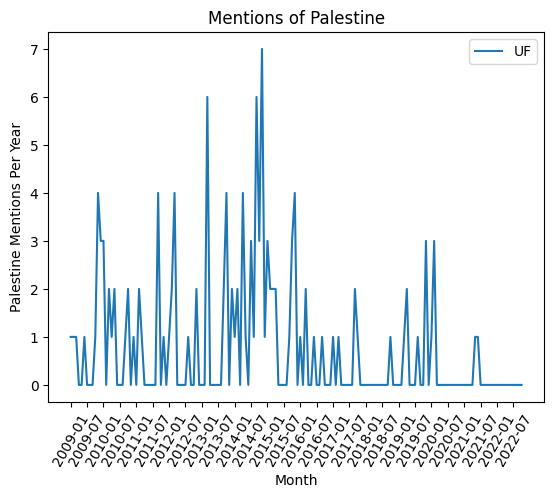

In [4]:
# Hyperparameters to Modify
school_name = 'UF'
string = "Palestine"
time_slice = 'monthly'

from helpers.graphers import grapher
from helpers.queries import count_query

school_names = [school_name]
save_pattern = '_'.join(school_names)+'_'+string.replace(' ','_')
grapher(school_names=school_names,
        pipeline=[],
        query=count_query(string),
        y_label=f"{string} Mentions Per Year",
        data_path="grouped_data",
        data_name=save_pattern,
        time_slice=time_slice,
        title=f"Mentions of {string}",
        img_path=f"figures/{school_name}/{save_pattern}_{time_slice}.png")